# Transfer Learning with PyTorch

In this notebook, I will show you how to use transfer learning to train a model on a dataset that is different from the one it was originally trained on. 

- Foundataion Model: [VGG16](https://arxiv.org/abs/1409.1556)
- Original Dataset: [ImageNet](https://www.image-net.org/)
- New Dataset: [Cat and Dog](https://www.kaggle.com/datasets/tongpython/cat-and-dog)

# Download Dataset

Download Cat Dog dataset from [One Drive](https://ncku365-my.sharepoint.com/:u:/g/personal/nm6121030_ncku_edu_tw/EbTwo26N_lZOgDCca7v03YwBH-qgc2hpg3hWsHZ_yzgZWQ?e=PseGN4) and extract it to the current directory.

In [2]:
import os

if os.path.exists("cat_dog_kaggle"):
    print('Dataset already downloaded and extracted')
else:
    !bash download_dataset.sh

Dataset already downloaded and extracted


# Download the package

In [2]:
%pip -q install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Visualize the data

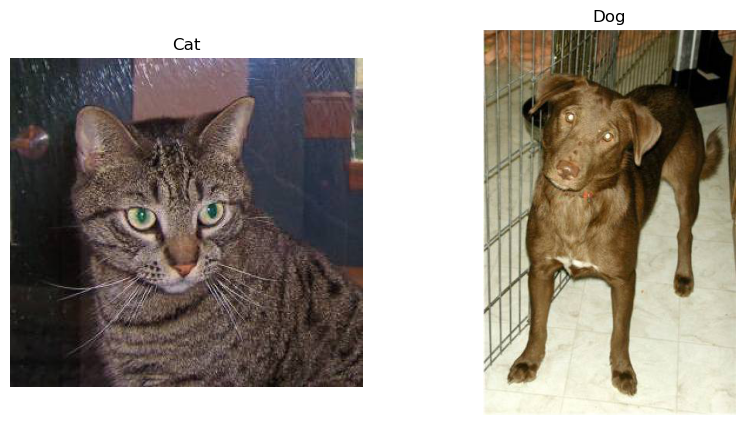

In [3]:
import matplotlib.pyplot as plt
import PIL

cat_img_path = './cat_dog_kaggle/training_set/cats/cat.1.jpg'
dog_img_path = './cat_dog_kaggle/training_set/dogs/dog.1.jpg'

cat_img = PIL.Image.open(cat_img_path)
dog_img = PIL.Image.open(dog_img_path)

plt.figure(figsize=(10, 5))
# Cat
plt.subplot(1, 2, 1)
plt.imshow(cat_img)
plt.title('Cat')
plt.axis('off')
# Dog
plt.subplot(1, 2, 2)
plt.imshow(dog_img)
plt.title('Dog')
plt.axis('off')
plt.show()

# Create Dataset and DataLoader

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchsummary import summary

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [6]:
train_dataset = datasets.ImageFolder(root='cat_dog_kaggle/training_set', transform=transform)
test_dataset = datasets.ImageFolder(root='cat_dog_kaggle/test_set', transform=transform)

In [7]:
print(f"Training set:")
print(f"Number of images: {len(train_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")
# show the len of each class
print(f"Dataset distribution:")
print(f"{train_dataset.classes[0]}: {train_dataset.targets.count(0)}")
print(f"{train_dataset.classes[1]}: {train_dataset.targets.count(1)}")

print("="*20)

print(f"Test set:")
print(f"Number of images: {len(test_dataset)}")
print(f"Number of classes: {len(test_dataset.classes)}")
print(f"Classes: {test_dataset.classes}")
# show the len of each class
print(f"Dataset distribution:")
print(f"{test_dataset.classes[0]}: {test_dataset.targets.count(0)}")
print(f"{test_dataset.classes[1]}: {test_dataset.targets.count(1)}")

Training set:
Number of images: 8005
Number of classes: 2
Classes: ['cats', 'dogs']
Dataset distribution:
cats: 4000
dogs: 4005
Test set:
Number of images: 2023
Number of classes: 2
Classes: ['cats', 'dogs']
Dataset distribution:
cats: 1011
dogs: 1012


In [8]:
# split the train dataset into 80% train and 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
# split
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")    # test set remains the same

Train dataset size: 6404
Validation dataset size: 1601
Test dataset size: 2023


In [9]:
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8)

# Import Foundation Model

VGG16(Very Deep Convolutional Network)

Model Structure:
- 13 convolutional layers
- 3 fully connected layers
- 5 max pooling layers

![VGG16](./src/VGG16.png)

In [10]:
# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [11]:
import torchvision.models as models
from torchvision.models import VGG16_Weights

# Load the pre-trained model
model = models.vgg16(weights=VGG16_Weights.DEFAULT).to(device)

In [12]:
# show the model architecture
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

# Hyperparameters

In [13]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 30

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train and Validate

In [14]:
# record the training and validation accuracy & loss
train_accuracy, train_loss = [], []
val_accuracy, val_loss = [], []

In [15]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    print(f'Epoch {epoch+1}/{num_epochs}')
    for idx, (images, labels) in enumerate(tqdm(train_loader)):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        # accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy.append(100 * correct / total)
    train_loss.append(running_loss / total)

    print(f'Training Loss: {train_loss[-1]:.4f}, Accuracy: {train_accuracy[-1]:.2f}%')
    
    # Validation
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # loss
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            # accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy.append(100 * correct / total)
    val_loss.append(running_loss / total)

    print(f'Validation Loss: {val_loss[-1]:.4f}, Accuracy: {val_accuracy[-1]:.2f}%')

Epoch 1/30


100%|██████████| 51/51 [00:33<00:00,  1.52it/s]

Training Loss: 0.0477, Accuracy: 48.14%


Validation Loss: 0.0057, Accuracy: 49.28%
Epoch 2/30


100%|██████████| 51/51 [00:33<00:00,  1.52it/s]

Training Loss: 0.0054, Accuracy: 56.62%


Validation Loss: 0.0054, Accuracy: 59.96%
Epoch 3/30


100%|██████████| 51/51 [00:33<00:00,  1.54it/s]

Training Loss: 0.0052, Accuracy: 61.16%


Validation Loss: 0.0063, Accuracy: 51.72%
Epoch 4/30


100%|██████████| 51/51 [00:33<00:00,  1.51it/s]

Training Loss: 0.0056, Accuracy: 55.17%


Validation Loss: 0.0102, Accuracy: 51.03%
Epoch 5/30


100%|██████████| 51/51 [00:33<00:00,  1.53it/s]

Training Loss: 0.0056, Accuracy: 56.75%


Validation Loss: 0.0059, Accuracy: 53.90%
Epoch 6/30


100%|██████████| 51/51 [00:33<00:00,  1.53it/s]

Training Loss: 0.0053, Accuracy: 61.20%


Validation Loss: 0.0051, Accuracy: 67.08%
Epoch 7/30


100%|██████████| 51/51 [00:33<00:00,  1.53it/s]

Training Loss: 0.0048, Accuracy: 67.25%


Validation Loss: 0.0049, Accuracy: 67.96%
Epoch 8/30


100%|██████████| 51/51 [00:33<00:00,  1.52it/s]

Training Loss: 0.0044, Accuracy: 71.74%


Validation Loss: 0.0044, Accuracy: 72.77%
Epoch 9/30


100%|██████████| 51/51 [00:32<00:00,  1.55it/s]

Training Loss: 0.0038, Accuracy: 76.95%


Validation Loss: 0.0038, Accuracy: 78.26%
Epoch 10/30


100%|██████████| 51/51 [00:33<00:00,  1.53it/s]

Training Loss: 0.0037, Accuracy: 78.26%


Validation Loss: 0.0045, Accuracy: 73.20%
Epoch 11/30


100%|██████████| 51/51 [00:33<00:00,  1.52it/s]

Training Loss: 0.0033, Accuracy: 80.53%


Validation Loss: 0.0039, Accuracy: 78.83%
Epoch 12/30


100%|██████████| 51/51 [00:33<00:00,  1.52it/s]

Training Loss: 0.0030, Accuracy: 83.65%


Validation Loss: 0.0034, Accuracy: 80.07%
Epoch 13/30


100%|██████████| 51/51 [00:33<00:00,  1.52it/s]

Training Loss: 0.0029, Accuracy: 83.42%


Validation Loss: 0.0029, Accuracy: 83.01%
Epoch 14/30


100%|██████████| 51/51 [00:33<00:00,  1.52it/s]

Training Loss: 0.0025, Accuracy: 86.07%


Validation Loss: 0.0027, Accuracy: 85.57%
Epoch 15/30


100%|██████████| 51/51 [00:33<00:00,  1.52it/s]

Training Loss: 0.0022, Accuracy: 88.51%


Validation Loss: 0.0029, Accuracy: 85.13%
Epoch 16/30


100%|██████████| 51/51 [00:33<00:00,  1.52it/s]

Training Loss: 0.0018, Accuracy: 90.44%


Validation Loss: 0.0025, Accuracy: 86.20%
Epoch 17/30


100%|██████████| 51/51 [00:33<00:00,  1.51it/s]

Training Loss: 0.0017, Accuracy: 91.66%


Validation Loss: 0.0028, Accuracy: 86.51%
Epoch 18/30


100%|██████████| 51/51 [00:33<00:00,  1.50it/s]

Training Loss: 0.0017, Accuracy: 91.13%


Validation Loss: 0.0027, Accuracy: 87.38%
Epoch 19/30


100%|██████████| 51/51 [00:33<00:00,  1.52it/s]

Training Loss: 0.0014, Accuracy: 93.14%


Validation Loss: 0.0037, Accuracy: 83.14%
Epoch 20/30


100%|██████████| 51/51 [00:33<00:00,  1.51it/s]

Training Loss: 0.0013, Accuracy: 93.50%


Validation Loss: 0.0023, Accuracy: 87.88%
Epoch 21/30


100%|██████████| 51/51 [00:32<00:00,  1.55it/s]

Training Loss: 0.0011, Accuracy: 94.57%


Validation Loss: 0.0034, Accuracy: 86.13%
Epoch 22/30


100%|██████████| 51/51 [00:33<00:00,  1.53it/s]

Training Loss: 0.0010, Accuracy: 94.72%


Validation Loss: 0.0026, Accuracy: 89.19%
Epoch 23/30


100%|██████████| 51/51 [00:33<00:00,  1.52it/s]


Training Loss: 0.0007, Accuracy: 96.67%
Validation Loss: 0.0053, Accuracy: 86.26%
Epoch 24/30


100%|██████████| 51/51 [00:33<00:00,  1.52it/s]

Training Loss: 0.0009, Accuracy: 95.74%


Validation Loss: 0.0028, Accuracy: 88.94%
Epoch 25/30


100%|██████████| 51/51 [00:33<00:00,  1.52it/s]


Training Loss: 0.0005, Accuracy: 97.75%
Validation Loss: 0.0081, Accuracy: 81.82%
Epoch 26/30


100%|██████████| 51/51 [00:33<00:00,  1.52it/s]

Training Loss: 0.0029, Accuracy: 84.85%


Validation Loss: 0.0039, Accuracy: 82.57%
Epoch 27/30


100%|██████████| 51/51 [00:33<00:00,  1.53it/s]

Training Loss: 0.0022, Accuracy: 88.26%


Validation Loss: 0.0030, Accuracy: 85.57%
Epoch 28/30


100%|██████████| 51/51 [00:33<00:00,  1.53it/s]

Training Loss: 0.0012, Accuracy: 93.86%


Validation Loss: 0.0033, Accuracy: 87.38%
Epoch 29/30


100%|██████████| 51/51 [00:33<00:00,  1.53it/s]

Training Loss: 0.0009, Accuracy: 95.86%


Validation Loss: 0.0024, Accuracy: 89.51%
Epoch 30/30


100%|██████████| 51/51 [00:33<00:00,  1.52it/s]

Training Loss: 0.0007, Accuracy: 96.80%


Validation Loss: 0.0033, Accuracy: 87.76%


# Visualize the results

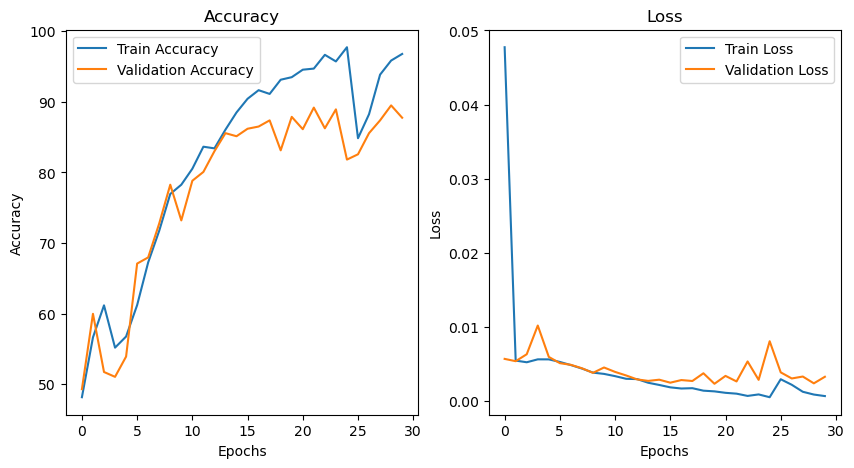

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# plot the training and validation accuracy and loss
plt.figure(figsize=(10, 5))
# accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# show
plt.show()

# Test

In [17]:
test_accuracy = 0
total = 0

model.eval()
with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # accuracy
        total += labels.size(0)
        test_accuracy += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * test_accuracy / total:.2f}%')

Test Accuracy: 89.42%
